# DeClarE Model on Snopes dataset

The DeClarE model is a state of the art fake news detection model that uses Depp learning techniques to classify any input article as being fake or not. This model proposed by Popat et al.(2018) provides a nodel approach to input analysis. As opossed to other fake news detectin models, DeClarE uses external sources to the art as well for classification. It uses the claim text as well as the article and claim source. So in total the model take four inputs including the article itself. The code for DeClarE which is used as the base here can be found at https://github.com/connectsoumya/declare/blob/master/network.py.

## All imports

In [1]:
# Needed for weights visualization
!pip install keract

In [2]:
# The model used in this notebook is a modified version of https://github.com/connectsoumya/declare/blob/master/network.py
# All imports
import json
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import gzip
import spacy
from IPython.display import HTML

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_curve, auc

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Average, Embedding, RepeatVector
from keras.layers.pooling import MaxPooling2D , GlobalMaxPooling1D
from keras.layers.merge import concatenate

from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Dot, Average
from keras.backend import mean, expand_dims, gradients, function, tile
from keras.layers import Lambda
from keras.regularizers import l2,l1
from keras.layers import Dropout
from keras.optimizers import SGD, Adam
from keract import get_activations
import matplotlib.pyplot as plt
import os
import shutil
import smart_open
from sys import platform
from scipy import spatial
import gensim
from gensim.models.keyedvectors import KeyedVectors

Using TensorFlow backend.


In [0]:
# Random seed set to ensure that code provides the same output whenever randomisation is done.
seed = 128
np.random.seed(seed)

In [4]:
# Get the Snopes Dataset from the location provided in the DeClarE paper.
!wget http://resources.mpi-inf.mpg.de/impact/dl_cred_analysis/Snopes.zip
!unzip Snopes.zip

--2020-04-20 00:18:37--  http://resources.mpi-inf.mpg.de/impact/dl_cred_analysis/Snopes.zip
Resolving resources.mpi-inf.mpg.de (resources.mpi-inf.mpg.de)... 139.19.206.46
Connecting to resources.mpi-inf.mpg.de (resources.mpi-inf.mpg.de)|139.19.206.46|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5559754 (5.3M) [application/zip]
Saving to: ‘Snopes.zip’

Snopes.zip          100%[===================>]   5.30M  29.8MB/s    in 0.2s    

2020-04-20 00:18:38 (29.8 MB/s) - ‘Snopes.zip’ saved [5559754/5559754]

Archive:  Snopes.zip
   creating: Snopes/
  inflating: Snopes/README           
  inflating: Snopes/snopes.tsv       


In [5]:
# Download the Glove.zip file and expand it.
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2020-04-20 00:18:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-04-20 00:18:47--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-04-20 00:18:47--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

## Snopes Data Load

In [0]:
# Loading the Snopes csv file
facts=list()

fact=pd.read_csv('./Snopes/snopes.tsv', delimiter = '\t', names = ['cred_label','claim_id','claim_text','article','article_source'])

In [7]:
# The structure of the snopes.tsv file is following: <cred_label>\t<claim_id>\t<claim_text>\t<article>\t<article_source>
fact.head()

,cred_label,claim_id,claim_text,article,article_source
0,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,there are several holidays throughout that tim...,www.godlikeproductions.com
1,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,defenses against same photographs show images ...,www.sjpba.net
2,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,the best that life could think out we extended...,www.englisher.net
3,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,this entry november 19 2006 published 9 years ...,rss2.com
4,true,politics_christmas_bestbuy,best buy chain eschewing use word christmas 20...,place he will not do either said snape the ord...,www.englisher.net


In [8]:
# Get the data statistics
label_counts = fact['cred_label'].value_counts()
print(label_counts.describe())
top_labels = label_counts.nlargest(10)
top_labels_list = top_labels.index.tolist()
print(top_labels)

count        4.000000
mean      7310.500000
std       9874.341176
min        144.000000
25%        395.250000
50%       3921.000000
75%      10836.250000
max      21256.000000
Name: cred_label, dtype: float64
false           21256
true             7363
mostly false      479
mostly true       144
Name: cred_label, dtype: int64


## Pre-Process the data

In [9]:
# Convert the credibility labels to binary labels where 0 is false and 1 is true.
claim_label = fact['cred_label']
# {'False', 'Half-True', 'Mostly False', 'Mostly True', 'Pants on Fire!', 'True'}
claim_label = [1 if tuple == 'true'  or tuple == 'mostly true' else 0 for tuple in claim_label]

col = ['claim_label']
lbl = pd.DataFrame(claim_label,columns=col)
label_counts = lbl['claim_label'].value_counts()
print(label_counts.describe())
top_labels = label_counts.nlargest(10)
top_labels_list = top_labels.index.tolist()
print(top_labels)

count        2.000000
mean     14621.000000
std      10060.715283
min       7507.000000
25%      11064.000000
50%      14621.000000
75%      18178.000000
max      21735.000000
Name: claim_label, dtype: float64
0    21735
1     7507
Name: claim_label, dtype: int64


In [0]:
# Add the binary labels to the datafarme
fact['bin_cred_label'] = claim_label

In [0]:
# As can be seen from the statistics above, class 0 has 3 times more data than class 1
# Method to divide input data into true and false dataframes and return them
def divide_truefalse(fact):
  col = ['cred_label','claim_id','claim_text','article','article_source','bin_cred_label']
  true_data= list()
  false_data=list()
  for index, row in fact.iterrows():
    if row['cred_label'] == 'true' or row['cred_label'] == 'mostly true':
      true_data.append(row)
    else:
      false_data.append(row)

  data_frame_true = pd.DataFrame(true_data,columns=col)
  data_frame_false = pd.DataFrame(false_data,columns=col)
  return data_frame_true,data_frame_false

def slice_snopes(unique):
  true_claims = unique[unique["cred_label"] == 1]
  false_claims = unique[unique["cred_label"] == 0]
  false_claims = false_claims.head(int(len(false_claims)/3))
  return pd.concat([true_claims, false_claims]).sample(frac=1)

In [12]:
# Convert label to binary and check the datafarme statistics again
claim_label = fact['cred_label']
# {'false', 'mostly false', 'mostly true', 'true'}
claim_label = [1 if tuple == 'true' or tuple == 'mostly true' else 0 for tuple in claim_label]

col = ['claim_label']
lbl = pd.DataFrame(claim_label,columns=col)
label_counts = lbl['claim_label'].value_counts()
print(label_counts.describe())
top_labels = label_counts.nlargest(10)
top_labels_list = top_labels.index.tolist()
print(top_labels)

count        2.000000
mean     14621.000000
std      10060.715283
min       7507.000000
25%      11064.000000
50%      14621.000000
75%      18178.000000
max      21735.000000
Name: claim_label, dtype: float64
0    21735
1     7507
Name: claim_label, dtype: int64


In [13]:
fact["cred_label"]= claim_label
unique = fact.drop_duplicates("claim_text")
unique = slice_snopes(unique)
train_unique, big_unique = train_test_split(unique, test_size=0.2, random_state=8)
val_unique, test_unique = train_test_split(big_unique, test_size=0.5, random_state=8)

input_test = fact[fact["claim_text"].isin(test_unique["claim_text"])]
input_val = fact[fact["claim_text"].isin(val_unique["claim_text"])]
input_train = fact[fact["claim_text"].isin(train_unique["claim_text"])]
label_train = input_train["cred_label"]
label_test = input_test["cred_label"]
label_val = input_val["cred_label"]

print(len(input_train))

12119


## Create Training and Test Data for the model

In [0]:
# Get Train, Test and validation
#input_train_in,input_test,label_train_in,label_test = train_test_split(fact, claim_label, test_size=0.2, random_state=8)

In [15]:
# Code to check how many unique claims are present in the test set.
# Code found here: https://stackoverflow.com/questions/23460345/selecting-unique-rows-between-two-dataframes-in-pandas
unique_test = input_test[~input_test['claim_text'].isin(input_train['claim_text'])]
uniq_set=set(unique_test['claim_text'].tolist())
print("There are %d unique claims in the test set" % (len(uniq_set)))
print("Total unique rows are %d"%(len(unique_test)))

There are 215 unique claims in the test set
Total unique rows are 1533


In [16]:
# Get the claim division for the unique test data.
label_counts_uq = unique_test['bin_cred_label'].value_counts()
print(label_counts_uq.describe())
top_labels_uq = label_counts_uq.nlargest(5)
top_labels_list_uq = top_labels_uq.index.tolist()
print(top_labels_uq)

count      2.000000
mean     766.500000
std        0.707107
min      766.000000
25%      766.250000
50%      766.500000
75%      766.750000
max      767.000000
Name: bin_cred_label, dtype: float64
1    767
0    766
Name: bin_cred_label, dtype: int64


In [17]:
print(len(input_test))
# Training data columns as list
clm_list = input_train['claim_text'].tolist()
art_list = input_train['article'].tolist()
art_src_list = input_train['article_source'].tolist()

# Test data columns as list
test_clm_list = input_test['claim_text'].tolist()
test_art_list = input_test['article'].tolist()
test_art_src_list = input_test['article_source'].tolist()

1533


In [0]:
#Validation data columns as list
val_clm_list = input_val['claim_text'].tolist()
val_art_list = input_val['article'].tolist()
val_art_src_list = input_val['article_source'].tolist()

In [0]:
# For training data
# Article and claim embedding i.e. word embedding. Here the text to sequence conversions occurs.
t = Tokenizer()
t.fit_on_texts(clm_list + art_list)
encoded_claim = t.texts_to_sequences(clm_list)
encoded_art = t.texts_to_sequences(art_list)

max_len = max(encoded_claim, key=len)
max_len_c = 100
padded_claim = pad_sequences(encoded_claim, maxlen=max_len_c, padding='post')

max_len = max(encoded_art, key=len)
max_len_a = 100
padded_art = pad_sequences(encoded_art, maxlen=max_len_a, padding='post')

In [0]:
# Get the embedding matrix of the vocabulary from Glove 100.
vocab_size = len(t.word_index) + 1
embedding_dim = 100
word_index = t.word_index
def create_embed_matrix(vocab_size, embedding_dim,word_index):
  embedding_matrix = np.zeros((vocab_size, embedding_dim))
  with open('glove.6B.100d.txt') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
  return embedding_matrix
embedding_matrix = create_embed_matrix(vocab_size, embedding_dim, word_index)

In [21]:
# To find how many words of the input text the embedding contains 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.9999744199728852

In [0]:
# For article source embedding    
t_asrc = Tokenizer()
t_asrc.fit_on_texts(art_src_list)
encoded_art_src = t_asrc.texts_to_sequences(art_src_list)

max_len = max(encoded_art_src, key=len)
max_len_as = 4
padded_art_src = pad_sequences(encoded_art_src, maxlen=max_len_as, padding='post')
# Create embedding matrix for article source
vocab_size_asrc = len(t_asrc.word_index) + 1
embedding_matrix_asrc = create_embed_matrix(vocab_size_asrc, 4, t_asrc.word_index)

In [0]:
# Validation data
# Claim and article

encoded_claim_val = t.texts_to_sequences(val_clm_list)
encoded_art_val = t.texts_to_sequences(val_art_list)

max_len_val = max(encoded_claim_val, key=len)
max_len_c_val = 100
padded_claim_val = pad_sequences(encoded_claim_val, maxlen=max_len_c_val, padding='post')

max_len_val = max(encoded_art_val, key=len)
max_len_a_val = 100
padded_art_val = pad_sequences(encoded_art_val, maxlen=max_len_a_val, padding='post')

# Article Sources data
encoded_art_src_val = t_asrc.texts_to_sequences(val_art_src_list)

max_len_val = max(encoded_art_src_val, key=len)
max_len_as_val = 4
padded_art_src_val = pad_sequences(encoded_art_src_val, maxlen=max_len_as_val, padding='post')

In [0]:
# Test Data
# Claim and article

encoded_claim_test = t.texts_to_sequences(test_clm_list)
encoded_art_test = t.texts_to_sequences(test_art_list)

max_len_test = max(encoded_claim_test, key=len)
max_len_c_test = 100
padded_claim_test = pad_sequences(encoded_claim_test, maxlen=max_len_c_test, padding='post')

max_len_test = max(encoded_art_test, key=len)
max_len_a_test = 100
padded_art_test = pad_sequences(encoded_art_test, maxlen=max_len_a_test, padding='post')

# Article ources data
encoded_art_src_test = t_asrc.texts_to_sequences(test_art_src_list)

max_len_test = max(encoded_art_src_test, key=len)
max_len_as_test = 4
padded_art_src_test = pad_sequences(encoded_art_src_test, maxlen=max_len_as_test, padding='post')

In [0]:
# Method to plot the accuracy and los graph from the history object. Code found in https://realpython.com/python-keras-text-classification/
plt.style.use('ggplot')
from google.colab import files
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig("hi.svg", format="svg")
    files.download('hi.svg')

In [0]:
def get_results(model_name, dataset_name, predictions, true_labels):
  precision = precision_score(predictions, true_labels, average='macro')
  recall = recall_score(predictions, true_labels, average='macro')
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1, average='macro')
  f1_micro = fbeta_score(predictions, true_labels,1, average="micro") #1 means f_1 measure
  fpr, tpr, thresholds = roc_curve(true_labels, predictions)
  auc_full = auc(fpr, tpr)

  return {"model_name":model_name,
                  "dataset_name": dataset_name,
                  "precision":precision,
                  "recall": recall,
                  "accuracy": accuracy,
                  "f1": f1,
                  "f1_micro": f1_micro,
                  "auc": auc_full}

def list_to_dict(results):
  big_results = {"model_name": [],
                 "dataset_name": [],
                "precision": [],
                 "recall": [],
                 "accuracy": [],
                 "f1": [],
                 "f1_micro": [],
                 "auc": []}
  for result in results:
    for key in result:
      big_results[key].append(result[key])

  return pd.DataFrame.from_dict(big_results)

def process_results(big_results):
  return (big_results["model_name"][0], big_results["dataset_name"][0], big_results.mean(), big_results.std())

## Bi-LSTM- Simple DeClarE (lr=0.002 & 0.0001)

In [0]:
# # This DeCalrE model only uses Bi-LSTM called Simple DeClarE
lstm_op_dim = 64
art_wrd1 = Input(shape=(max_len_a,))
art_wrd_emb1 = Embedding(vocab_size, 100, input_length=max_len_a, weights=[embedding_matrix], trainable=False)(art_wrd1) # article embedding
lstm_op2 = Bidirectional(LSTM(lstm_op_dim, return_sequences=True, recurrent_regularizer=l2(0.00001), kernel_regularizer=l2(0.01)),
                         merge_mode='concat')(art_wrd_emb1) # Bi-LSTM layer
# Fatten layer
flat = Flatten()(lstm_op2)
# Article source embedding
art_src1 = Input(shape = (max_len_as,))
art_src_emb1 = Embedding(vocab_size_asrc, 4, input_length=max_len_as, weights=[embedding_matrix_asrc], trainable=False)(art_src1)
art_src_emb_flatten1 = Flatten()(art_src_emb1)

# End dense layers
dense1 = Dense(8, activation='relu',kernel_regularizer=l2(0.01))(flat)
dense1 = Dense(1, activation='sigmoid',kernel_regularizer=l2(0.01))(dense1)

model_lstm2 = Model(inputs=art_wrd1, outputs=dense1)
adam = Adam(lr=0.0001)
#adam = Adam(lr=0.002) # Also used in the second pass
model_lstm2.compile(optimizer=adam,
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
print(model_lstm2.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 100)          3909300   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          84480     
_________________________________________________________________
flatten_3 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 102408    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 4,096,197
Trainable params: 186,897
Non-trainable params: 3,909,300
___________________________________________

In [0]:
# Convert the predicted values to 0 or 1
def get_proper_labels(y_pred):
  prop_label = [1 if tuple>=0.5 else 0 for tuple in y_pred]
  return prop_label

In [0]:
results = []
for i in range(10):
  history3 = model_lstm2.fit(padded_art, label_train,
                    epochs=30,
                    validation_data=(padded_art_val, label_val),
                    batch_size=100)
  y_pred3 = model_lstm2.predict(padded_art_test)
  y_pred_bin3 = get_proper_labels(y_pred3)
  result = get_results("deClaRe", "snopes", y_pred_bin3, label_test)
  print(result)
  results.append(result)
process_results(list_to_dict(results))

Train on 12119 samples, validate on 1507 samples
Epoch 1/30
12119/12119 [==============================] - 62s 5ms/step - loss: 0.5673 - accuracy: 0.8163 - val_loss: 0.9699 - val_accuracy: 0.6019
Epoch 2/30
12119/12119 [==============================] - 59s 5ms/step - loss: 0.5655 - accuracy: 0.8204 - val_loss: 0.9115 - val_accuracy: 0.6244
Epoch 3/30
12119/12119 [==============================] - 59s 5ms/step - loss: 0.5564 - accuracy: 0.8220 - val_loss: 0.9183 - val_accuracy: 0.6092
Epoch 4/30
12119/12119 [==============================] - 58s 5ms/step - loss: 0.5460 - accuracy: 0.8310 - val_loss: 0.9811 - val_accuracy: 0.6105
Epoch 5/30
12119/12119 [==============================] - 58s 5ms/step - loss: 0.5377 - accuracy: 0.8373 - val_loss: 0.9383 - val_accuracy: 0.6231
Epoch 6/30
12119/12119 [==============================] - 59s 5ms/step - loss: 0.5287 - accuracy: 0.8418 - val_loss: 0.9579 - val_accuracy: 0.6171
Epoch 7/30
12119/12119 [==============================] - 59s 5ms/ste

('deClaRe', 'snopes', precision    0.580753
 recall       0.581832
 accuracy     0.580757
 f1           0.579339
 f1_micro     0.580757
 auc          0.580753
 dtype: float64, precision    0.008874
 recall       0.008740
 accuracy     0.008865
 f1           0.009410
 f1_micro     0.008865
 auc          0.008874
 dtype: float64)

In [0]:
# Train model with lr=0.0001
history_001 = model_lstm2.fit(padded_art, label_train,
                    epochs=30,
                    validation_data=(padded_art_val, label_val),
                    batch_size=100)

Train on 9924 samples, validate on 2481 samples
Epoch 1/30
9924/9924 [==============================] - 35s 4ms/step - loss: 3.4270 - acc: 0.5460 - val_loss: 3.0983 - val_acc: 0.5941
Epoch 2/30
9924/9924 [==============================] - 30s 3ms/step - loss: 2.8326 - acc: 0.6225 - val_loss: 2.5814 - val_acc: 0.6417
Epoch 3/30
9924/9924 [==============================] - 30s 3ms/step - loss: 2.3750 - acc: 0.6449 - val_loss: 2.1818 - val_acc: 0.6590
Epoch 4/30
9924/9924 [==============================] - 30s 3ms/step - loss: 2.0228 - acc: 0.6609 - val_loss: 1.8777 - val_acc: 0.6606
Epoch 5/30
9924/9924 [==============================] - 30s 3ms/step - loss: 1.7512 - acc: 0.6736 - val_loss: 1.6469 - val_acc: 0.6638
Epoch 6/30
9924/9924 [==============================] - 30s 3ms/step - loss: 1.5357 - acc: 0.6786 - val_loss: 1.4512 - val_acc: 0.6703
Epoch 7/30
9924/9924 [==============================] - 30s 3ms/step - loss: 1.3610 - acc: 0.6907 - val_loss: 1.3065 - val_acc: 0.6715
Epoch 8

Validation Accuracy: 0.7299
3102/3102 [==============================] - 4s 1ms/step
Testing Accuracy:  0.7166


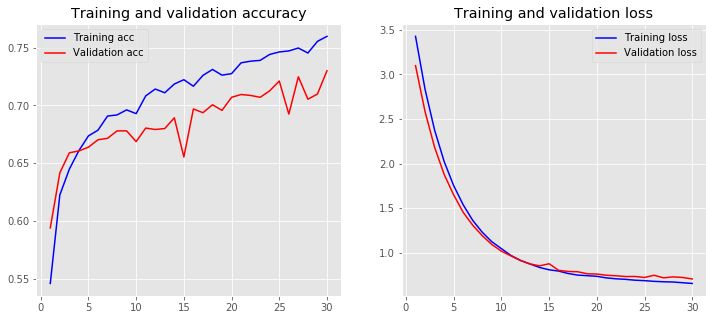

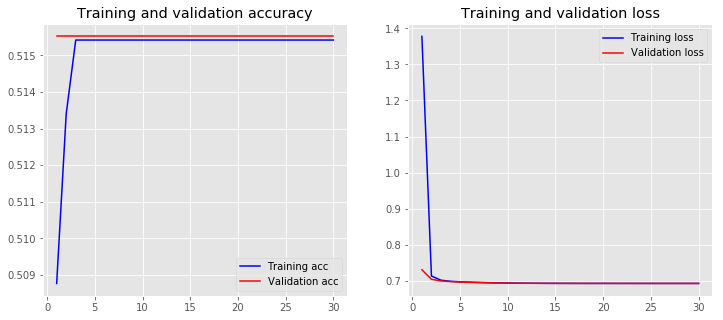

In [0]:
# Plot the accuracy and loss graphs for when lr = 0.0001 and 0.002
loss, accuracy = model_lstm2.evaluate(padded_art_val, label_val, verbose=False)
print("Validation Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_lstm2.evaluate(padded_art_test,label_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_001)
plot_history(history_002)

In [0]:
# Predict the test data when lr=0.0001
y_pred = model_lstm2.predict(padded_art_test)

### Misc functions

In [0]:
# Convert the predicted values to 0 or 1
def get_proper_labels(y_pred):
  prop_label = [1 if tuple>=0.5 else 0 for tuple in y_pred]
  return prop_label

In [0]:
# Method to plot the confusion matrix. Code taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=['False','True'], yticklabels=['False','True'],
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.grid(False)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [0]:
# Code taken from Lab5 of TaD by Jeff Dalton. This method returns the accuarcy, precision, recall and F1 measure values for an input.
def evaluation_summary(description, predictions, true_labels):
  print("Evaluation for: " + description)
  precision = precision_score(predictions, true_labels, average='macro')
  recall = recall_score(predictions, true_labels, average='macro')
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1, average='macro') #1 means f_1 measure
  print("Classifier '%s' has Acc=%0.4f P=%0.4f R=%0.4f F1=%0.4f" % (description,accuracy,precision,recall,f1))
  print(classification_report(predictions, true_labels, digits=3))
  print('\nConfusion matrix:\n',confusion_matrix(true_labels, predictions))
  return precision,recall,accuracy,f1

### Model Evaluation

In [0]:
# Get the binary values of the predicted data 
y_pred_bin = get_proper_labels(y_pred)

Confusion matrix, without normalization
[[1153  453]
 [ 426 1070]]
Normalized confusion matrix
[[0.71793275 0.28206725]
 [0.28475936 0.71524064]]


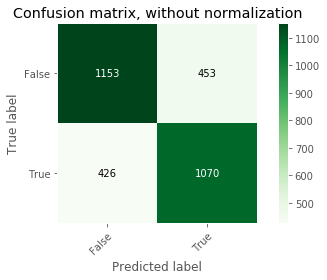

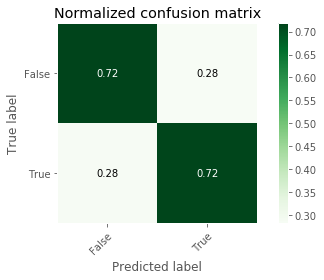

In [0]:
# When lr=0.0001
plot_confusion_matrix(label_test,y_pred_bin,[0,1])
plot_confusion_matrix(label_test,y_pred_bin,[0,1], normalize=True)

In [0]:
# When lr=0.0001
basic_p,basc_r,basic_a,basic_f1 = evaluation_summary("DeClare-Basic", y_pred_bin, label_test)

Evaluation for: DeClare-Basic
Classifier 'DeClare-Basic' has Acc=0.7166 P=0.7166 R=0.7164 F1=0.7164
              precision    recall  f1-score   support

           0      0.718     0.730     0.724      1579
           1      0.715     0.703     0.709      1523

    accuracy                          0.717      3102
   macro avg      0.717     0.716     0.716      3102
weighted avg      0.717     0.717     0.717      3102


Confusion matrix:
 [[1153  453]
 [ 426 1070]]


In [0]:
# Calculate the AUC value of the result when lr=0.0001
fpr, tpr, thresholds = roc_curve(label_test, y_pred_bin)
auc_basic = auc(fpr, tpr)
print("DeClarE Basic AUC-",auc_basic)

DeClarE Basic AUC- 0.7165866969452788


In [0]:
#Predict the test data when lr=0.002
y_pred = model_lstm2.predict(padded_art_test)

Confusion matrix, without normalization
[[1606    0]
 [1496    0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


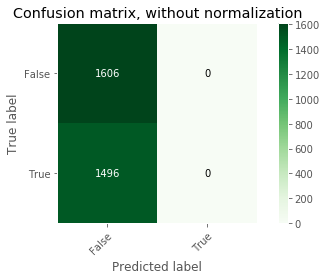

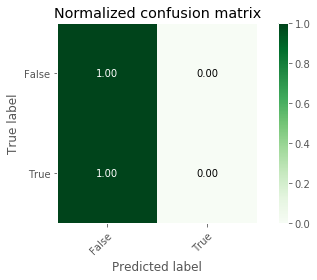

In [0]:
#When lr=0.02
y_pred_bin = get_proper_labels(y_pred)
plot_confusion_matrix(label_test,y_pred_bin,[0,1])
plot_confusion_matrix(label_test,y_pred_bin,[0,1], normalize=True)

In [0]:
# This is the outcome when lr=0.002
basic_p,basc_r,basic_a,basic_f1 = evaluation_summary("DeClare-Basic", y_pred_bin, label_test)

Evaluation for: DeClare-Basic
Classifier 'DeClare-Basic' has Acc=0.5177 P=0.5000 R=0.2589 F1=0.3411
              precision    recall  f1-score   support

           0      1.000     0.518     0.682      3102
           1      0.000     0.000     0.000         0

    accuracy                          0.518      3102
   macro avg      0.500     0.259     0.341      3102
weighted avg      1.000     0.518     0.682      3102


Confusion matrix:
 [[1606    0]
 [1496    0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
#When lr=0.002
fpr, tpr, thresholds = roc_curve(label_test, y_pred_bin)
auc_basic = auc(fpr, tpr)
print("DeClarE Basic AUC-",auc_basic)

DeClarE Basic AUC- 0.5


## DeClarE Simple + Attn (lr=0.002 & 0.0001)

In [0]:
# DeClarE model- Simple + Attention
lstm_op_dim = 64

clm_wrd = Input(shape=(max_len_c,))
clm_wrd_emb = Embedding(vocab_size, 100, input_length=max_len_c, weights=[embedding_matrix], trainable=False)(clm_wrd) # claim embedding
mean_clm_wrd_emb = Lambda(lambda xin: mean(xin, axis=1))(clm_wrd_emb) #Average of the embedding using lambda 
mean_clm_wrd_emb_exp = RepeatVector(100)(mean_clm_wrd_emb) # Repeat vector to increase the matrix size for flatten
mean_clm_wrd_emb_flat = Flatten()(mean_clm_wrd_emb_exp) # Flatten layer

art_wrd1 = Input(shape=(max_len_a,))
art_wrd_emb1 = Embedding(vocab_size, 100, input_length=max_len_a, weights=[embedding_matrix], trainable=False)(art_wrd1) # article embedding
art_wrd_emb_flat = Flatten()(art_wrd_emb1) # Flatten layer

ip_to_dense = concatenate(axis=-1, inputs = [mean_clm_wrd_emb_flat, art_wrd_emb_flat]) # concatenation of article and claim embedding
# Attention mechanism
attn_weights = Dense(128, activation='tanh')(ip_to_dense)
attn_weights = Activation('softmax')(attn_weights)

model_attn_wts = Model(inputs=[clm_wrd, art_wrd1], outputs=attn_weights)
# Bi-LSTM on article embedding
lstm_op2 = Bidirectional(LSTM(lstm_op_dim, return_sequences=True, recurrent_regularizer=l2(0.00001), kernel_regularizer=l2(0.01)),
                         merge_mode='concat')(art_wrd_emb1)
model_lstm = Model(inputs=art_wrd1, outputs=lstm_op2)

# Dot product of output of attention mechanism and Bi-LSTM
inner_pdt = Dot(axes=-1)([model_attn_wts.output, model_lstm.output])
inner_pdt = RepeatVector(3)(inner_pdt)
mean_dim = Lambda(lambda xin: mean(xin, axis=-1))(inner_pdt)

# End dense layers
dense1 = Dense(8, activation='relu',kernel_regularizer=l2(0.01))(mean_dim)
drop1 = Dropout(rate = 0.2)(dense1)
dense1 = Dense(8, activation='relu',kernel_regularizer=l2(0.01))(drop1)
dense1 = Dense(1, activation='sigmoid',kernel_regularizer=l2(0.01))(dense1)

model_dec1 = Model(inputs=[clm_wrd,art_wrd1], outputs=dense1)
#adam = Adam(lr=0.002) # Also used on the second pass
adam = Adam(lr=0.0001)
model_dec1.compile(optimizer=adam,
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
print(model_dec1.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 100)     3909300     input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 100)          0           embedding_3[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 100)          0                                            
____________________________________________________________________________________________

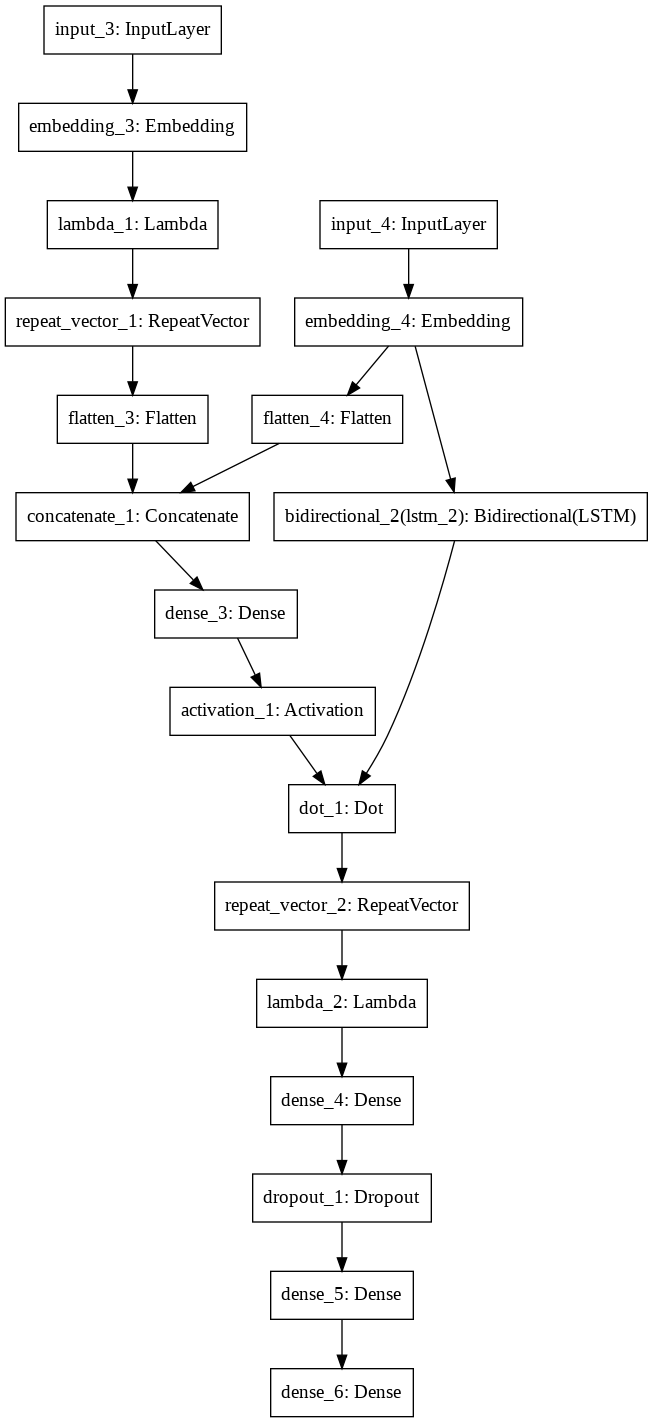

In [0]:
# Get the image of the model structure as PNG
plot_model(model_dec1, to_file='declare_art_cl.png')

In [0]:
results = []
for i in range(10):
  history3 = model_dec1.fit([padded_claim,padded_art], label_train,
                    epochs=30,
                    validation_data=([padded_claim_val,padded_art_val], label_val),
                    batch_size=100)
  y_pred3 = model_dec1.predict([padded_claim_test,padded_art_test])
  y_pred_bin3 = get_proper_labels(y_pred3)
  result = get_results("deClaRe", "snopes", y_pred_bin3, label_test)
  print(result)
  results.append(result)
process_results(list_to_dict(results))

Train on 12119 samples, validate on 1507 samples
Epoch 1/30
12119/12119 [==============================] - 40s 3ms/step - loss: 3.3474 - accuracy: 0.5251 - val_loss: 2.9965 - val_accuracy: 0.4764
Epoch 2/30
12119/12119 [==============================] - 36s 3ms/step - loss: 2.7016 - accuracy: 0.5791 - val_loss: 2.4360 - val_accuracy: 0.5328
Epoch 3/30
12119/12119 [==============================] - 36s 3ms/step - loss: 2.1959 - accuracy: 0.6172 - val_loss: 2.0068 - val_accuracy: 0.5607
Epoch 4/30
12119/12119 [==============================] - 36s 3ms/step - loss: 1.8031 - accuracy: 0.6927 - val_loss: 1.6842 - val_accuracy: 0.5581
Epoch 5/30
12119/12119 [==============================] - 36s 3ms/step - loss: 1.5005 - accuracy: 0.7469 - val_loss: 1.4368 - val_accuracy: 0.5813
Epoch 6/30
12119/12119 [==============================] - 36s 3ms/step - loss: 1.2674 - accuracy: 0.7865 - val_loss: 1.2515 - val_accuracy: 0.5926
Epoch 7/30
12119/12119 [==============================] - 37s 3ms/ste

('deClaRe', 'snopes', precision    0.568466
 recall       0.569219
 accuracy     0.568493
 f1           0.567267
 f1_micro     0.568493
 auc          0.568466
 dtype: float64, precision    0.003213
 recall       0.002576
 accuracy     0.003199
 f1           0.005081
 f1_micro     0.003199
 auc          0.003213
 dtype: float64)

In [0]:
# Model training when lr=0.002
history3_02 = model_dec1.fit([padded_claim,padded_art], label_train,
                    epochs=30,
                    validation_data=([padded_claim_val,padded_art_val], label_val),
                    batch_size=100)

Train on 9924 samples, validate on 2481 samples
Epoch 1/30
9924/9924 [==============================] - 39s 4ms/step - loss: 1.3192 - acc: 0.5149 - val_loss: 0.7439 - val_acc: 0.5155
Epoch 2/30
9924/9924 [==============================] - 36s 4ms/step - loss: 0.7242 - acc: 0.5154 - val_loss: 0.7100 - val_acc: 0.5155
Epoch 3/30
9924/9924 [==============================] - 36s 4ms/step - loss: 0.7032 - acc: 0.5154 - val_loss: 0.6982 - val_acc: 0.5155
Epoch 4/30
9924/9924 [==============================] - 36s 4ms/step - loss: 0.6960 - acc: 0.5154 - val_loss: 0.6943 - val_acc: 0.5155
Epoch 5/30
9924/9924 [==============================] - 36s 4ms/step - loss: 0.6937 - acc: 0.5154 - val_loss: 0.6931 - val_acc: 0.5155
Epoch 6/30
9924/9924 [==============================] - 36s 4ms/step - loss: 0.6930 - acc: 0.5154 - val_loss: 0.6928 - val_acc: 0.5155
Epoch 7/30
9924/9924 [==============================] - 36s 4ms/step - loss: 0.6928 - acc: 0.5154 - val_loss: 0.6927 - val_acc: 0.5155
Epoch 8

Validation Accuracy: 0.6683
3102/3102 [==============================] - 4s 1ms/step
Testing Accuracy:  0.6667
LR=0.0001,LR=0.002


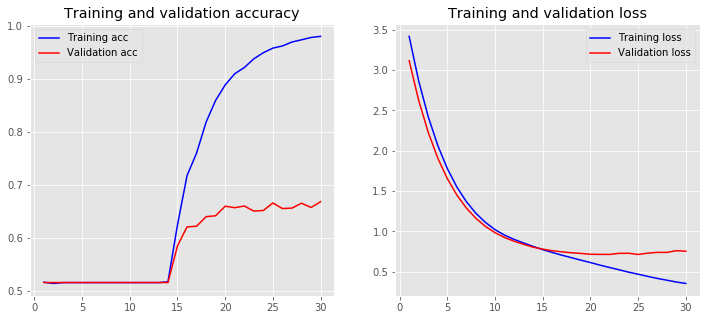

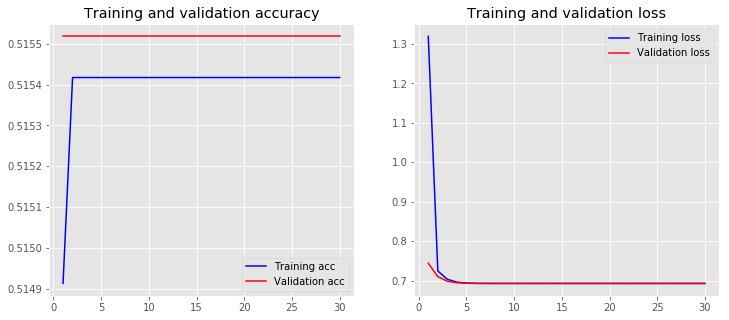

In [0]:
# get the loss and accuracy graphs for both the learning rates
loss, accuracy = model_dec1.evaluate([padded_claim_val,padded_art_val], label_val, verbose=False)
print("Validation Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_dec1.evaluate([padded_claim_test,padded_art_test],label_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history3)
print('LR=0.0001,LR=0.002')
plot_history(history3_02)

In [0]:
# Predict the test data and convert to 0 or 1 value
y_pred3 = model_dec1.predict([padded_claim_test,padded_art_test])
y_pred_bin3 = get_proper_labels(y_pred3)

Confusion matrix, without normalization
[[1223  383]
 [ 651  845]]
Normalized confusion matrix
[[0.7615193  0.2384807 ]
 [0.43516043 0.56483957]]


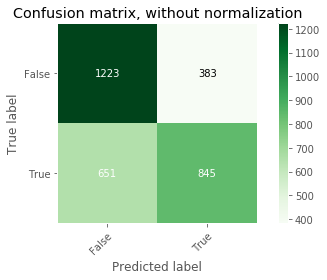

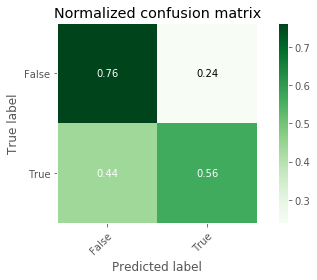

In [0]:
#When lr=0.0001
plot_confusion_matrix(label_test,y_pred_bin3,[0,1])
plot_confusion_matrix(label_test,y_pred_bin3,[0,1], normalize=True)

Confusion matrix, without normalization
[[1606    0]
 [1496    0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


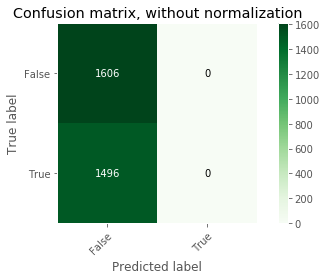

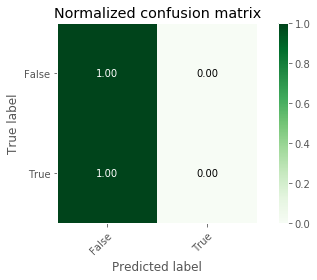

In [0]:
# When lr=0.002
plot_confusion_matrix(label_test,y_pred_bin3,[0,1])
plot_confusion_matrix(label_test,y_pred_bin3,[0,1], normalize=True)

In [0]:
#When lr=0.0001
basic_att_p,basc_att_r,basic_att_a,basic_att_f1 = evaluation_summary("DeClare-Basic_Attn", y_pred_bin3, label_test)

Evaluation for: DeClare-Basic_Attn
Classifier 'DeClare-Basic_Attn' has Acc=0.6667 P=0.6632 R=0.6704 F1=0.6616
              precision    recall  f1-score   support

           0      0.762     0.653     0.703      1874
           1      0.565     0.688     0.620      1228

    accuracy                          0.667      3102
   macro avg      0.663     0.670     0.662      3102
weighted avg      0.684     0.667     0.670      3102


Confusion matrix:
 [[1223  383]
 [ 651  845]]


In [0]:
#When lr=0.0001
fpr, tpr, thresholds = roc_curve(label_test, y_pred_bin3)
auc_basic_att = auc(fpr, tpr)
print("DeClarE Basic_Attn AUC-",auc_basic_att)

DeClarE Basic_Attn AUC- 0.6631794374038532


In [0]:
#When lr=0.02
basic_att_p,basc_att_r,basic_att_a,basic_att_f1 = evaluation_summary("DeClare-Basic_Attn", y_pred_bin3, label_test)

Evaluation for: DeClare-Basic_Attn
Classifier 'DeClare-Basic_Attn' has Acc=0.5177 P=0.5000 R=0.2589 F1=0.3411
              precision    recall  f1-score   support

           0      1.000     0.518     0.682      3102
           1      0.000     0.000     0.000         0

    accuracy                          0.518      3102
   macro avg      0.500     0.259     0.341      3102
weighted avg      1.000     0.518     0.682      3102


Confusion matrix:
 [[1606    0]
 [1496    0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
# When lr=0.002
fpr, tpr, thresholds = roc_curve(label_test, y_pred_bin3)
auc_basic_att = auc(fpr, tpr)
print("DeClarE Basic_Attn AUC-",auc_basic_att)

DeClarE Basic_Attn AUC- 0.5


## Bi-LSTM- Simple + SourceEmb DeClarE (lr=0.002)

In [0]:
# DeClarE Model- Simple + Source Embeddings
lstm_op_dim = 64
art_wrd1 = Input(shape=(max_len_a,))
art_wrd_emb1 = Embedding(vocab_size, 100, input_length=max_len_a, weights=[embedding_matrix], trainable=False)(art_wrd1) # article embedding
lstm_op2 = Bidirectional(LSTM(lstm_op_dim, return_sequences=True, recurrent_regularizer=l2(0.00001), kernel_regularizer=l2(0.01)),
                         merge_mode='concat')(art_wrd_emb1) # Bi-LSTM layer
# Fatten layer
flat = Flatten()(lstm_op2)

# Article source embedding
art_src1 = Input(shape = (max_len_as,))
art_src_emb1 = Embedding(vocab_size_asrc, 4, input_length=max_len_as, weights=[embedding_matrix_asrc], trainable=False)(art_src1)
art_src_emb_flatten1 = Flatten()(art_src_emb1)

#Concatenate the article with the article source embedding
con = concatenate(inputs = [flat, art_src_emb_flatten1])

# End dense layers
dense1 = Dense(8, activation='relu',kernel_regularizer=l2(0.01))(con)
dense1 = Dense(1, activation='sigmoid',kernel_regularizer=l2(0.01))(dense1)

model_lstm3 = Model(inputs=[art_wrd1,art_src1], outputs=dense1)
#adam = Adam(lr=0.002) #Also used on the second pass
adam = Adam(lr=0.0001)
model_lstm3.compile(optimizer=adam,
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
print(model_lstm3.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 100, 100)     3736800     input_14[0][0]                   
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 4)            0                                            
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 100, 128)     84480       embedding_14[0][0]               
__________________________________________________________________________________________________
embedding_

In [0]:
#Model training when lr=0.0001
history2_01 = model_lstm3.fit([padded_art,padded_art_src], label_train,
                    epochs=30,
                    validation_data=([padded_art_val,padded_art_src_val], label_val),
                    batch_size=100)

Train on 9924 samples, validate on 2481 samples
Epoch 1/30
9924/9924 [==============================] - 36s 4ms/step - loss: 3.4243 - acc: 0.5349 - val_loss: 3.0961 - val_acc: 0.5977
Epoch 2/30
9924/9924 [==============================] - 30s 3ms/step - loss: 2.8302 - acc: 0.6022 - val_loss: 2.5751 - val_acc: 0.6360
Epoch 3/30
9924/9924 [==============================] - 30s 3ms/step - loss: 2.3680 - acc: 0.6376 - val_loss: 2.1727 - val_acc: 0.6465
Epoch 4/30
9924/9924 [==============================] - 30s 3ms/step - loss: 2.0111 - acc: 0.6545 - val_loss: 1.8623 - val_acc: 0.6695
Epoch 5/30
9924/9924 [==============================] - 30s 3ms/step - loss: 1.7345 - acc: 0.6692 - val_loss: 1.6219 - val_acc: 0.6771
Epoch 6/30
9924/9924 [==============================] - 30s 3ms/step - loss: 1.5169 - acc: 0.6816 - val_loss: 1.4354 - val_acc: 0.6667
Epoch 7/30
9924/9924 [==============================] - 30s 3ms/step - loss: 1.3443 - acc: 0.6891 - val_loss: 1.2835 - val_acc: 0.6832
Epoch 8

In [0]:
#Model training when lr=0.002
history2 = model_lstm3.fit([padded_art,padded_art_src], label_train,
                    epochs=30,
                    validation_data=([padded_art_val,padded_art_src_val], label_val),
                    batch_size=100)

Train on 9924 samples, validate on 2481 samples
Epoch 1/30
9924/9924 [==============================] - 34s 3ms/step - loss: 1.3715 - acc: 0.5081 - val_loss: 0.7348 - val_acc: 0.5155
Epoch 2/30
9924/9924 [==============================] - 30s 3ms/step - loss: 0.7176 - acc: 0.5125 - val_loss: 0.7069 - val_acc: 0.5155
Epoch 3/30
9924/9924 [==============================] - 30s 3ms/step - loss: 0.7035 - acc: 0.5154 - val_loss: 0.7011 - val_acc: 0.5155
Epoch 4/30
9924/9924 [==============================] - 30s 3ms/step - loss: 0.7000 - acc: 0.5154 - val_loss: 0.6990 - val_acc: 0.5155
Epoch 5/30
9924/9924 [==============================] - 30s 3ms/step - loss: 0.6983 - acc: 0.5154 - val_loss: 0.6977 - val_acc: 0.5155
Epoch 6/30
9924/9924 [==============================] - 30s 3ms/step - loss: 0.6972 - acc: 0.5154 - val_loss: 0.6967 - val_acc: 0.5155
Epoch 7/30
9924/9924 [==============================] - 30s 3ms/step - loss: 0.6963 - acc: 0.5154 - val_loss: 0.6959 - val_acc: 0.5155
Epoch 8

Validation Accuracy: 0.7110
3102/3102 [==============================] - 4s 1ms/step
Testing Accuracy:  0.7112


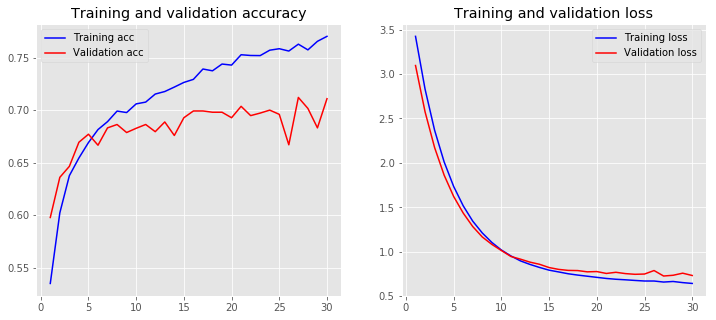

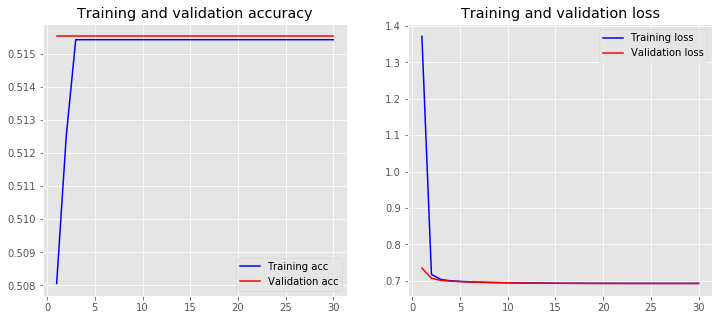

In [0]:
# Get the loss and accuracy graphs of both the learning rates
loss, accuracy = model_lstm3.evaluate([padded_art_val,padded_art_src_val], label_val, verbose=False)
print("Validation Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_lstm3.evaluate([padded_art_test,padded_art_src_test],label_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history2_01)
plot_history(history2)

In [0]:
# Predict the test data
y_pred2 = model_lstm3.predict([padded_art_test,padded_art_src_test])
y_pred_bin2 = get_proper_labels(y_pred2)

Confusion matrix, without normalization
[[1087  519]
 [ 377 1119]]
Normalized confusion matrix
[[0.67683686 0.32316314]
 [0.25200535 0.74799465]]


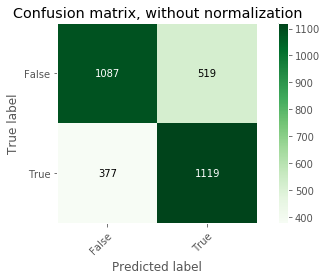

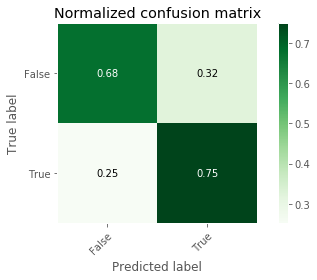

In [0]:
#When lr=0.0001
plot_confusion_matrix(label_test,y_pred_bin2,[0,1])
plot_confusion_matrix(label_test,y_pred_bin2,[0,1], normalize=True)

Confusion matrix, without normalization
[[1606    0]
 [1496    0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


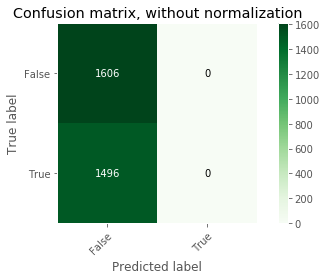

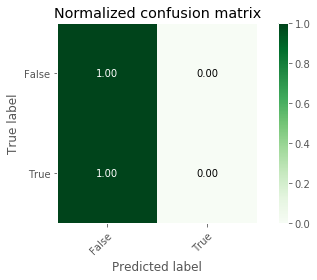

In [0]:
#When lr=0.002
plot_confusion_matrix(label_test,y_pred_bin2,[0,1])
plot_confusion_matrix(label_test,y_pred_bin2,[0,1], normalize=True)

In [0]:
#When lr=0.0001
basic_src_p,basc_src_r,basic_src_a,basic_src_f1 = evaluation_summary("DeClare-Basic_srcEmb", y_pred_bin2, label_test)

Evaluation for: DeClare-Basic_srcEmb
Classifier 'DeClare-Basic_srcEmb' has Acc=0.7112 P=0.7124 R=0.7128 F1=0.7111
              precision    recall  f1-score   support

           0      0.677     0.742     0.708      1464
           1      0.748     0.683     0.714      1638

    accuracy                          0.711      3102
   macro avg      0.712     0.713     0.711      3102
weighted avg      0.714     0.711     0.711      3102


Confusion matrix:
 [[1087  519]
 [ 377 1119]]


In [0]:
# When lr=0.0001
fpr, tpr, thresholds = roc_curve(label_test, y_pred_bin2)
auc_basic_src = auc(fpr, tpr)
print("DeClarE Basic_srcEmb AUC-",auc_basic_src)

DeClarE Basic_srcEmb AUC- 0.7124157570873929


In [0]:
# When lr=0.002
basic_src_p,basc_src_r,basic_src_a,basic_src_f1 = evaluation_summary("DeClare-Basic_srcEmb", y_pred_bin2, label_test)

Evaluation for: DeClare-Basic_srcEmb
Classifier 'DeClare-Basic_srcEmb' has Acc=0.5177 P=0.5000 R=0.2589 F1=0.3411
              precision    recall  f1-score   support

           0      1.000     0.518     0.682      3102
           1      0.000     0.000     0.000         0

    accuracy                          0.518      3102
   macro avg      0.500     0.259     0.341      3102
weighted avg      1.000     0.518     0.682      3102


Confusion matrix:
 [[1606    0]
 [1496    0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
# When lr=0.002
fpr, tpr, thresholds = roc_curve(label_test, y_pred_bin2)
auc_basic_src = auc(fpr, tpr)
print("DeClarE Basic_srcEmb AUC-",auc_basic_src)

DeClarE Basic_srcEmb AUC- 0.5


## DeClarE Full Model (lr=0.002 & 0.0001)

In [27]:
# From https://github.com/connectsoumya/declare/blob/master/network.py
# DeClarE Full
from keras.layers import Lambda
lstm_op_dim = 50#64

clm_wrd = Input(shape=(max_len_c,))
clm_wrd_emb = Embedding(vocab_size, 100, input_length=max_len_c, weights=[embedding_matrix], trainable=False)(clm_wrd) # claim embedding
# Average layer created through a lambda function 
mean_clm_wrd_emb = Lambda(lambda xin: mean(xin, axis=1))(clm_wrd_emb) 
mean_clm_wrd_emb_exp = RepeatVector(100)(mean_clm_wrd_emb) # Repeat vector to increase the the output dimensions for flatten
mean_clm_wrd_emb_flat = Flatten()(mean_clm_wrd_emb_exp) # Flatten layer

art_wrd1 = Input(shape=(max_len_a,))
art_wrd_emb1 = Embedding(vocab_size, 100, input_length=max_len_a, weights=[embedding_matrix], trainable=False)(art_wrd1) # article embedding
art_wrd_emb_flat = Flatten()(art_wrd_emb1)

ip_to_dense = concatenate(inputs = [mean_clm_wrd_emb_flat, art_wrd_emb_flat]) # concatenate article and claim embedding
# Attention mechanism
attn_weights = Dense(100, activation='tanh')(ip_to_dense)
attn_weights = Activation('softmax')(attn_weights)

model_attn_wts = Model(inputs=[clm_wrd, art_wrd1], outputs=attn_weights)
# Bi-LSTM layer on article embedding
lstm_op2 = Bidirectional(LSTM(lstm_op_dim, return_sequences=True, recurrent_regularizer=l2(0.00001), kernel_regularizer=l2(0.01)),
                         merge_mode='concat')(art_wrd_emb1)
model_lstm = Model(inputs=art_wrd1, outputs=lstm_op2)
# Dot product between the output of Bi-LSTM and attention mechanism
inner_pdt = Dot(axes=-1)([model_attn_wts.output, model_lstm.output])
inner_pdt = RepeatVector(3)(inner_pdt) # Repeat vector to increase the dimension of the output
mean_dim = Lambda(lambda xin: mean(xin, axis=-1))(inner_pdt) # Average of the output
# Article source embedding
art_src1 = Input(shape = (max_len_as,))
art_src_emb1 = Embedding(vocab_size_asrc, 4, input_length=max_len_as, weights=[embedding_matrix_asrc], trainable=False)(art_src1)
art_src_emb_flatten1 = Flatten()(art_src_emb1)

#Concatenate article source embedding with the result of the dot product mean
con = concatenate(inputs = [mean_dim, art_src_emb_flatten1])

dense1 = Dense(8, activation='relu',kernel_regularizer=l2(0.01))(con)
drop1 = Dropout(rate = 0.2)(dense1)
dense1 = Dense(8, activation='relu',kernel_regularizer=l2(0.01))(dense1)
dense1 = Dense(1, activation='sigmoid',kernel_regularizer=l2(0.01))(dense1)
model_dec2 = Model(inputs=[clm_wrd,art_wrd1,art_src1], outputs=dense1)
#adam = Adam(lr=0.002) # Also used on the second pass
adam = Adam(lr=0.0001)
model_dec2.compile(optimizer=adam,
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
print(model_dec2.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 100)     3909300     input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 100)          0           embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
____________________________________________________________________________________________

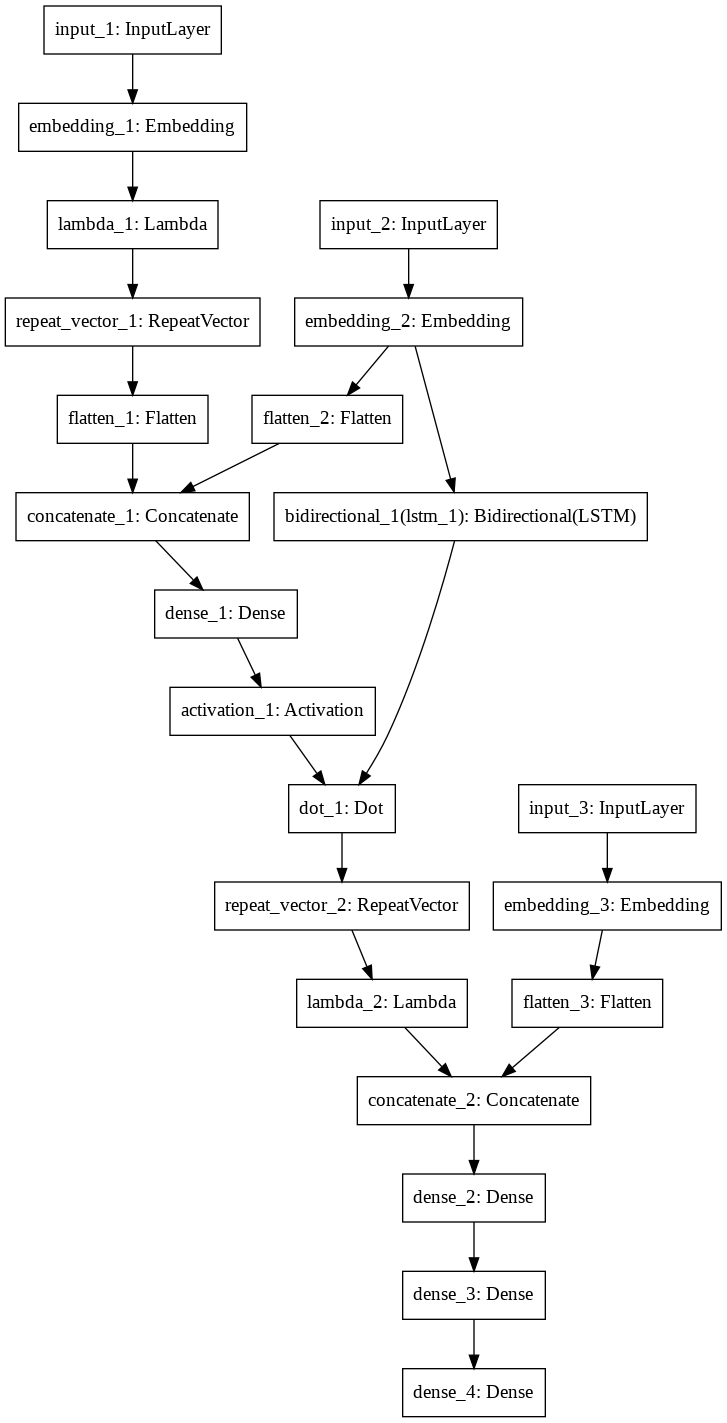

In [28]:
# get the model structure as png
plot_model(model_dec2, to_file='declare_full.png')

In [29]:
#Train model when lr=0.0001

history4 = model_dec2.fit([padded_claim,padded_art,padded_art_src], label_train,
                    epochs=30,
                    validation_data=([padded_claim_val,padded_art_val,padded_art_src_val], label_val),
                    batch_size=100)

Train on 12119 samples, validate on 1507 samples
Epoch 1/30
12119/12119 [==============================] - 42s 4ms/step - loss: 3.2379 - accuracy: 0.4943 - val_loss: 2.9241 - val_accuracy: 0.5415
Epoch 2/30
12119/12119 [==============================] - 39s 3ms/step - loss: 2.6793 - accuracy: 0.4989 - val_loss: 2.4335 - val_accuracy: 0.5322
Epoch 3/30
12119/12119 [==============================] - 39s 3ms/step - loss: 2.2400 - accuracy: 0.5132 - val_loss: 2.0469 - val_accuracy: 0.5382
Epoch 4/30
12119/12119 [==============================] - 39s 3ms/step - loss: 1.8928 - accuracy: 0.5622 - val_loss: 1.7426 - val_accuracy: 0.5680
Epoch 5/30
12119/12119 [==============================] - 39s 3ms/step - loss: 1.6193 - accuracy: 0.6057 - val_loss: 1.5048 - val_accuracy: 0.5912
Epoch 6/30
12119/12119 [==============================] - 38s 3ms/step - loss: 1.4044 - accuracy: 0.6360 - val_loss: 1.3188 - val_accuracy: 0.5926
Epoch 7/30
12119/12119 [==============================] - 39s 3ms/ste

In [0]:
#Model training when lr=0.002
history4_02 = model_dec2.fit([padded_claim,padded_art,padded_art_src], label_train,
                    epochs=30,
                    validation_data=([padded_claim_val,padded_art_val,padded_art_src_val], label_val),
                    batch_size=100)

Train on 9924 samples, validate on 2481 samples
Epoch 1/30
9924/9924 [==============================] - 36s 4ms/step - loss: 1.3687 - acc: 0.5182 - val_loss: 0.7601 - val_acc: 0.5127
Epoch 2/30
9924/9924 [==============================] - 32s 3ms/step - loss: 0.7303 - acc: 0.5161 - val_loss: 0.7113 - val_acc: 0.5155
Epoch 3/30
9924/9924 [==============================] - 32s 3ms/step - loss: 0.7032 - acc: 0.5154 - val_loss: 0.6978 - val_acc: 0.5155
Epoch 4/30
9924/9924 [==============================] - 32s 3ms/step - loss: 0.6956 - acc: 0.5154 - val_loss: 0.6941 - val_acc: 0.5155
Epoch 5/30
9924/9924 [==============================] - 32s 3ms/step - loss: 0.6935 - acc: 0.5154 - val_loss: 0.6930 - val_acc: 0.5155
Epoch 6/30
9924/9924 [==============================] - 32s 3ms/step - loss: 0.6929 - acc: 0.5154 - val_loss: 0.6928 - val_acc: 0.5155
Epoch 7/30
9924/9924 [==============================] - 32s 3ms/step - loss: 0.6928 - acc: 0.5154 - val_loss: 0.6927 - val_acc: 0.5155
Epoch 8

Validation Accuracy: 0.6384
1533/1533 [==============================] - 1s 953us/step
Testing Accuracy:  0.5740


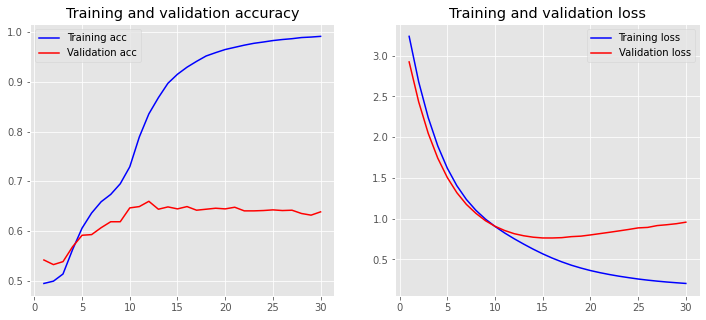

In [34]:
# Get the loss and accuracy graphs for both learning rates
loss, accuracy = model_dec2.evaluate([padded_claim_val,padded_art_val,padded_art_src_val], label_val, verbose=False)
print("Validation Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_dec2.evaluate([padded_claim_test,padded_art_test,padded_art_src_test],label_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history4)
#plot_history(history4_02)

In [0]:
# Predict for the test data and convert the result to either 0 or 1
y_pred4 = model_dec2.predict([padded_claim_test,padded_art_test,padded_art_src_test])
y_pred_bin4 = get_proper_labels(y_pred4)

Confusion matrix, without normalization
[[1186  420]
 [ 633  863]]
Normalized confusion matrix
[[0.7384807  0.2615193 ]
 [0.42312834 0.57687166]]


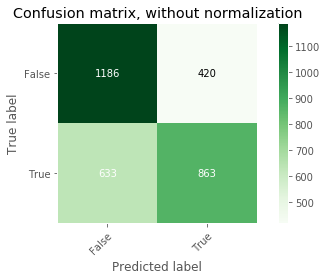

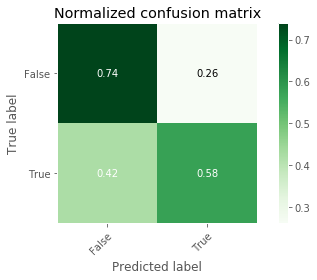

In [0]:
# When lr=0.0001
plot_confusion_matrix(label_test,y_pred_bin4,[0,1])
plot_confusion_matrix(label_test,y_pred_bin4,[0,1], normalize=True)

Confusion matrix, without normalization
[[1606    0]
 [1496    0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


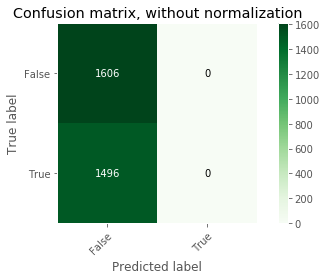

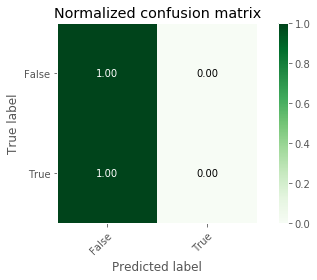

In [0]:
#When lr=0.002
plot_confusion_matrix(label_test,y_pred_bin4,[0,1])
plot_confusion_matrix(label_test,y_pred_bin4,[0,1], normalize=True)

In [0]:
#When lr=0.0001
decalre_p,declare_r,declare_a,declare_f1 = evaluation_summary("DeClarE-Full", y_pred_bin4, label_test)

Evaluation for: DeClarE-Full
Classifier 'DeClarE-Full' has Acc=0.6605 P=0.6577 R=0.6623 F1=0.6568
              precision    recall  f1-score   support

           0      0.738     0.652     0.693      1819
           1      0.577     0.673     0.621      1283

    accuracy                          0.661      3102
   macro avg      0.658     0.662     0.657      3102
weighted avg      0.672     0.661     0.663      3102


Confusion matrix:
 [[1186  420]
 [ 633  863]]


In [0]:
#When lr=0.0001
fpr, tpr, thresholds = roc_curve(label_test, y_pred_bin4)
auc_declare = auc(fpr, tpr)
print("DeClarE Full AUC-",auc_declare)

DeClarE Full AUC- 0.6576761775694089


In [0]:
#When lr=0.002
decalre_p,declare_r,declare_a,declare_f1 = evaluation_summary("DeClarE-Full", y_pred_bin4, label_test)

Evaluation for: DeClarE-Full
Classifier 'DeClarE-Full' has Acc=0.5177 P=0.5000 R=0.2589 F1=0.3411
              precision    recall  f1-score   support

           0      1.000     0.518     0.682      3102
           1      0.000     0.000     0.000         0

    accuracy                          0.518      3102
   macro avg      0.500     0.259     0.341      3102
weighted avg      1.000     0.518     0.682      3102


Confusion matrix:
 [[1606    0]
 [1496    0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
#When lr=0.002
fpr, tpr, thresholds = roc_curve(label_test, y_pred_bin4)
auc_declare = auc(fpr, tpr)
print("DeClarE Full AUC-",auc_declare)

DeClarE Full AUC- 0.5


In [0]:
# Visulaisation
#Creates and HTML file which show the attention weights visulaization on the article. This code taken from: https://github.com/kaushalshetty/Structured-Self-Attention/blob/master

def createHTML(texts, weights, fileName):
    """
    Creates a html file with text heat.
	weights: attention weights for visualizing
	texts: text on which attention weights are to be visualized
    """
    fileName = "visualization/"+fileName
    fOut = open(fileName, "w", encoding="utf-8")
    part1 = """
    <html lang="en">
    <head>
    <meta http-equiv="content-type" content="text/html; charset=utf-8">
    <style>
    body {
    font-family: Sans-Serif;
    }
    </style>
    </head>
    <body>
    <h3>
    Heatmaps
    </h3>
    </body>
    <script>
    """
    part2 = """
    var color = "255,0,0";
    var ngram_length = 3;
    var half_ngram = 1;
    for (var k=0; k < any_text.length; k++) {
    var tokens = any_text[k].split(" ");
    var intensity = new Array(tokens.length);
    var max_intensity = Number.MIN_SAFE_INTEGER;
    var min_intensity = Number.MAX_SAFE_INTEGER;
    for (var i = 0; i < intensity.length; i++) {
    intensity[i] = 0.0;
    for (var j = -half_ngram; j < ngram_length-half_ngram; j++) {
    if (i+j < intensity.length && i+j > -1) {
    intensity[i] += trigram_weights[k][i + j];
    }
    }
    if (i == 0 || i == intensity.length-1) {
    intensity[i] /= 2.0;
    } else {
    intensity[i] /= 3.0;
    }
    if (intensity[i] > max_intensity) {
    max_intensity = intensity[i];
    }
    if (intensity[i] < min_intensity) {
    min_intensity = intensity[i];
    }
    }
    var denominator = max_intensity - min_intensity;
    for (var i = 0; i < intensity.length; i++) {
    intensity[i] = (intensity[i] - min_intensity) / denominator;
    }
    if (k%2 == 0) {
    var heat_text = "<p><br><b>Example:</b><br>";
    } else {
    var heat_text = "<b>Example:</b><br>";
    }
    var space = "";
    for (var i = 0; i < tokens.length; i++) {
    heat_text += "<span style='background-color:rgba(" + color + "," + intensity[i] + ")'>" + space + tokens[i] + "</span>";
    if (space == "") {
    space = " ";
    }
    }
    //heat_text += "<p>";
    document.body.innerHTML += heat_text;
    }
    </script>
    </html>"""
    putQuote = lambda x: "\"%s\""%x
    textsString = "var any_text = [%s];\n"%(",".join(map(putQuote, texts)))
    weightsString = "var trigram_weights = [%s];\n"%(",".join(map(str,weights)))
    fOut.write(part1)
    fOut.write(textsString)
    fOut.write(weightsString)
    fOut.write(part2)
    fOut.close()
  
    return

In [0]:
# Create a new directory called visualization 
!mkdir visualization

In [0]:
#Method to process the article and the attention weights then create the HTML file.
def visualize_attention(wts,x_test_pad,word_to_id,filename):
    wts_add = wts
    wts_add_list = wts_add.tolist()
    id_to_word = {v:k for k,v in word_to_id.items()}
    text= []
    for test in x_test_pad:
        line=list()
        for i in test:
          if i == 0.0:
            word = '<UNK>'
          else:
            word = id_to_word.get(i)
          line.append(word)
        text.append(" ".join(line))
    
    createHTML(text, wts_add_list, filename)
    print("Attention visualization created for {} samples".format(len(x_test_pad)))
    return

In [0]:
# Get the activations of all layers of the model
test_last_idx = 15
activations = get_activations(model_dec2, [padded_claim_test[:test_last_idx,:],padded_art_test[:test_last_idx,:],
                                           padded_art_src_test[:test_last_idx,:]])

In [0]:
# Display the layer structures
from keract import display_activations
display_activations(activations, cmap="gray", save=False)

input_9:0 (15, 100) -> Skipped. First dimension is not 1.
input_10:0 (15, 100) -> Skipped. First dimension is not 1.
input_11:0 (15, 4) -> Skipped. First dimension is not 1.
embedding_9/embedding_lookup/Identity:0 (15, 100, 100) -> Skipped. First dimension is not 1.
lambda_3/Mean:0 (15, 100) -> Skipped. First dimension is not 1.
repeat_vector_3/Tile:0 (15, 100, 100) -> Skipped. First dimension is not 1.
embedding_10/embedding_lookup/Identity:0 (15, 100, 100) -> Skipped. First dimension is not 1.
flatten_9/Reshape:0 (15, 10000) -> Skipped. First dimension is not 1.
flatten_10/Reshape:0 (15, 10000) -> Skipped. First dimension is not 1.
concatenate_4/concat:0 (15, 20000) -> Skipped. First dimension is not 1.
dense_11/Tanh:0 (15, 100) -> Skipped. First dimension is not 1.
activation_2/Softmax:0 (15, 100) -> Skipped. First dimension is not 1.
bidirectional_5/concat:0 (15, 100, 100) -> Skipped. First dimension is not 1.
dot_2/Squeeze:0 (15, 100) -> Skipped. First dimension is not 1.
repeat_v

In [0]:
# get weights of the activation layer
wts = activations.get('activation_2/Softmax:0')
wts.shape

(15, 100)

In [0]:
# Create the weight visualization HTML file
word_to_id = t.word_index
visualize_attention(wts,padded_art_test[:test_last_idx,:],word_to_id,filename='declare_snp.html')

Attention visualization created for 15 samples


## Testing for Unique Claims

Due to the problem of experimental bias introduced into the model, we test the performance of the Hybrid model on unique claims. This bias is introduced because a claim can be associated with many articles and hence can be repeated in traning and test data making it seen data for the model when testing.

In [0]:
# For the Full DeClarE model when lr=0.0001
input_test['model_pred_01'] = y_pred_bin4
input_test.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,cred_label,claim_id,claim_text,article,article_source,bin_cred_label,model_pred,model_pred_01
651,false,politics_religion_marines,aclu objected us marine prayer session constit...,money out of the found by report spam use the ...,ennals.org,0,0,0
2123,false,politics_satire_palinczech,sarah palin called invasion czech republic res...,p v m tt historia ja tiede jump to navigation ...,www.tiede.fi,0,0,0
7418,false,invisible-art,new york artist named lana creates sells invis...,paying millions user name remember me password...,www.thephora.net,0,0,0
3383,false,crime_warnings_burundanga,criminals us using business cards incapacitate...,and slipping you a card when they offer their ...,groups.yahoo.com,0,0,0
19246,true,photos_accident_pushcar,video shows truck pushing automobile trapped f...,tanker truck at truck pushes car down highway ...,evyryl.prv.pl,1,0,1


In [0]:
#When lr=0.002
unique_test_or = input_test[~input_test['claim_text'].isin(input_train_in['claim_text'])]
unique_test_or.head()

,cred_label,claim_id,claim_text,article,article_source,bin_cred_label,model_pred
6157,true,holidays_christmas_photos_decorations,photograph shows holiday display depicting hom...,the legends information and misinformation tha...,www.sjpba.net,1,0
23491,mostly true,trayvon-martin-space-camp,photograph shows shooting victim trayvon marti...,read more false george zimmerman found dead fo...,hoax.trendolizer.com,1,0
9511,true,politics_war_onleave,civilians give seats commercial flight soldier...,offline quote quick reply remove advertisement...,www.puff.com,1,0
5648,true,humor_mediagoofs_sixpence2,urban myths board game fell joke using nursery...,a true legend a red indicates a false one and ...,www.j-dubbstheater.com,1,0
27614,true,politics_obama_photos_crashers,photograph shows barack obama posing couple cr...,comment culture travel life women fashion luxu...,www.telegraph.co.uk,1,0


In [0]:
#When lr=0.0001
unique_test_or1 = input_test[~input_test['claim_text'].isin(input_train_in['claim_text'])]
unique_test_or1.head()

,cred_label,claim_id,claim_text,article,article_source,bin_cred_label,model_pred,model_pred_01
6157,true,holidays_christmas_photos_decorations,photograph shows holiday display depicting hom...,the legends information and misinformation tha...,www.sjpba.net,1,0,1
23491,mostly true,trayvon-martin-space-camp,photograph shows shooting victim trayvon marti...,read more false george zimmerman found dead fo...,hoax.trendolizer.com,1,0,1
9511,true,politics_war_onleave,civilians give seats commercial flight soldier...,offline quote quick reply remove advertisement...,www.puff.com,1,0,1
5648,true,humor_mediagoofs_sixpence2,urban myths board game fell joke using nursery...,a true legend a red indicates a false one and ...,www.j-dubbstheater.com,1,0,0
27614,true,politics_obama_photos_crashers,photograph shows barack obama posing couple cr...,comment culture travel life women fashion luxu...,www.telegraph.co.uk,1,0,1


Confusion matrix, without normalization
[[35  0]
 [52  0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


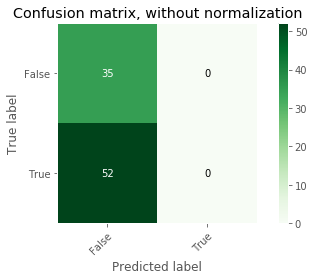

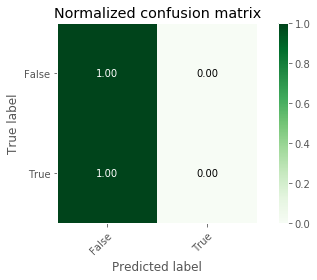

In [0]:
#When lr=0.0001
bin_pred1=unique_test_or1['bin_cred_label'].tolist()
pred_val1=unique_test_or1['model_pred_01'].tolist()
plot_confusion_matrix(bin_pred,pred_val,[0,1])
plot_confusion_matrix(bin_pred,pred_val,[0,1], normalize=True)

In [0]:
#When lr=0.0001
uq_p,uq_r,uq_a,uq_f1 = evaluation_summary("Self Attention-Full", pred_val, bin_pred)

Evaluation for: Self Attention-Full
Classifier 'Self Attention-Full' has Acc=0.4023 P=0.5000 R=0.2011 F1=0.2869
              precision    recall  f1-score   support

           0      1.000     0.402     0.574        87
           1      0.000     0.000     0.000         0

    accuracy                          0.402        87
   macro avg      0.500     0.201     0.287        87
weighted avg      1.000     0.402     0.574        87


Confusion matrix:
 [[35  0]
 [52  0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
#When lr=0.0001
fpr, tpr, thresholds = roc_curve(bin_pred, pred_val)
auc_basic = auc(fpr, tpr)
print("Self Attention-Full AUC-",auc_basic)

Self Attention-Full AUC- 0.5


Confusion matrix, without normalization
[[35  0]
 [52  0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


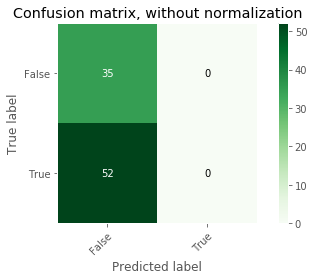

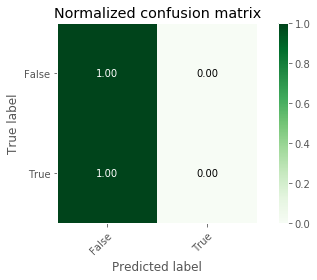

In [0]:
#When lr=0.002
bin_pred=unique_test_or['bin_cred_label'].tolist()
pred_val=unique_test_or['model_pred'].tolist()
plot_confusion_matrix(bin_pred,pred_val,[0,1])
plot_confusion_matrix(bin_pred,pred_val,[0,1], normalize=True)

In [0]:
#When lr=0.002
uq_p,uq_r,uq_a,uq_f1 = evaluation_summary("Self Attention-Full", pred_val, bin_pred)

Evaluation for: Self Attention-Full
Classifier 'Self Attention-Full' has Acc=0.4023 P=0.5000 R=0.2011 F1=0.2869
              precision    recall  f1-score   support

           0      1.000     0.402     0.574        87
           1      0.000     0.000     0.000         0

    accuracy                          0.402        87
   macro avg      0.500     0.201     0.287        87
weighted avg      1.000     0.402     0.574        87


Confusion matrix:
 [[35  0]
 [52  0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
#When lr=0.002
fpr, tpr, thresholds = roc_curve(bin_pred, pred_val)
auc_basic = auc(fpr, tpr)
print("Self Attention-Full AUC-",auc_basic)

Self Attention-Full AUC- 0.5


In [0]:
incorrect = unique_test_or[unique_test_or['bin_cred_label']!=unique_test_or['model_pred'].astype(int)]
incorrect

,cred_label,claim_id,claim_text,article,article_source,sim,bin_cred_label,model_pred
13103,true,radiotv_tv_marykay,early tv sitcom mary kay johnny first televisi...,who was the 1st married couple on tv to sleep ...,www.carfas.com,0.266778,1,0
168,false,food_warnings_kraftgmo,kraft macaroni cheese products carry warning l...,false rumor kraft macaroni cheese products car...,www.reddit.com,0.466861,0,1
17171,true,photos_people_peppers,photograph shows man named brian peppers regis...,brian peppers registered sex offender in ohio ...,hedonistica.com,0.280117,1,0
19963,true,politics_religion_walmarthalal,ohio walmart store begun selling halal meat,walmart to start selling halal meat in ohio we...,www.weaselzippers.us,0.333472,1,0
17799,true,business_hidden_tombihn,washing instruction tags tom bihn bags carried...,washing instruction tags on tom bihn bags carr...,www.abovetopsecret.com,0.420175,1,0
22115,true,luck_bennett,woman killed husband bidding play bridge hand ...,views mel mcconaghy home uncategorized true or...,www.northernstar-online.com,0.291788,1,0
6174,true,facebook-firearms-gun-sales-policy,facebook banned sale firearms,private sale of firearms now banned on faceboo...,www.socialsongbird.com,0.466861,1,0
9635,false,autos_law_strobe,flashing cars high beams traffic signal cause ...,does flashing your high beams trigger a red li...,www.quora.com,0.212210,0,1
23172,false,Politics_satire_july4,president obama advised group college students...,president obama advised a group of college stu...,www.reddit.com,0.466861,0,1
19573,true,language_document_hiringwomen,transportation magazine ran guide hiring women...,snopes transportation magazine ran a guide to ...,www.bagofnothing.com,0.466861,1,0


In [0]:
# Write to csv
unique_test_or.to_csv('declare_snopes.csv', sep='\t')

## Bibliography

Kashyap Popat, Subhabrata Mukherjee, Andrew Yates and Gerhard Weikum, <i>DeClarE: Debunking Fake News and False Claims using Evidence-Aware Deep Learning</i>, Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing, Pages 22-32, 2018.